In [44]:
import sys

sys.path.append('C:\\Users\\erik_\\Documents\\erik documents\\Programas\\PlasmaSimulations\\src')
# sys.path.append('...\\PlasmaSimulations\\src') # Replace dots with personal directory

%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from scipy.interpolate import BSpline
import time
from scipy.interpolate import splprep, splev
from scipy.stats import uniform,norm

import PIC_Solver
import PoissonSolvers

In [2]:
def sampling_dist(x,v):
    '''This sampling distribution represents a uniform distribution in x with L = Lx and a normal 
    distribution in v with mu = 0 and sigma = 1'''
    return 1.0/(L_x*np.sqrt(2*np.pi)) * np.exp(-v**2/2)

In [3]:
def maxwell_control_var(v):
    '''Variable control function'''
    return 1/(np.sqrt(2*np.pi)) * np.exp(-v**2/2)

In [4]:
######  Define the parameters  #######

## Positions
L_x = 2*np.pi/0.5 # Distance in positions direction
N_x = 128 # Number of slots in the x direction
print('L_x: ',L_x)

## Velocities
L_v = 10 # Distance in velocities direction
v_min = -L_v/2 # Min velocity
v_max = L_v/2 # Max velocity
N_v = 256 # Number of slots in the v direction 

## Time
T_max = 20 # Max integration time
M = 200 # Number of iterations

## Particle information
N_k = int(5e4) # Number of markers (particles)
q = -1 # Electron charge (adimensional)
mass = 1 # Electron mass (adimensional)

# Spline degree
spl_degree = 3

L_x:  12.566370614359172


In [5]:
# N_k, x_min, x_max, N_x, x_distribution, v_min, v_max, N_v, v_distribution, T, M, sampling_distribution,
# control_variate, spline_degree

obj = PIC_Solver.PIC(N_k, q, mass, 0.0, L_x, N_x, 'uniform', v_min, v_max, N_v, 'normal', T_max, M, sampling_dist,
                    maxwell_control_var, spl_degree, 'PIC1')

In [6]:
dx = obj.dx # position step
print('dx: ',dx)

dv = obj.dv # velocity step
print('dv: ',dv)

dt = obj.dt # time step
print('dt: ',dt)

dx:  0.09817477042468103
dv:  0.0390625
dt:  0.1


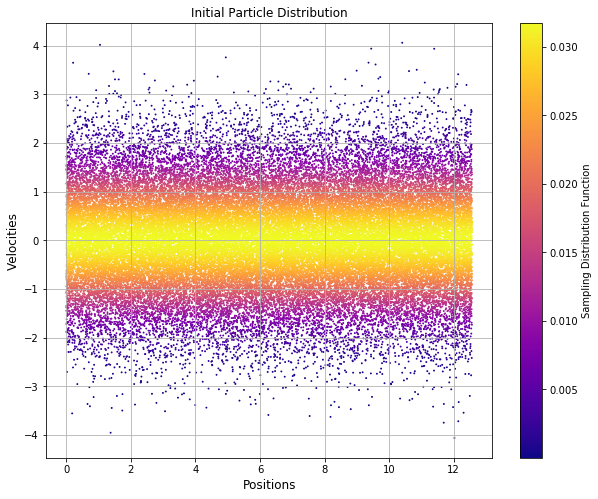

In [7]:
fig,ax = plt.subplots(figsize = (10,8))
ax.set_xlabel('Positions',fontsize = 'large')
ax.set_ylabel('Velocities',fontsize = 'large')
s = ax.scatter(obj.positions_sampling,obj.velocities_sampling ,s=0.8,
               c = sampling_dist(obj.positions_sampling,obj.velocities_sampling),cmap='plasma')
plt. title('Initial Particle Distribution')
plt.grid()
fig.colorbar(s ,label = 'Sampling Distribution Function')
plt.show()

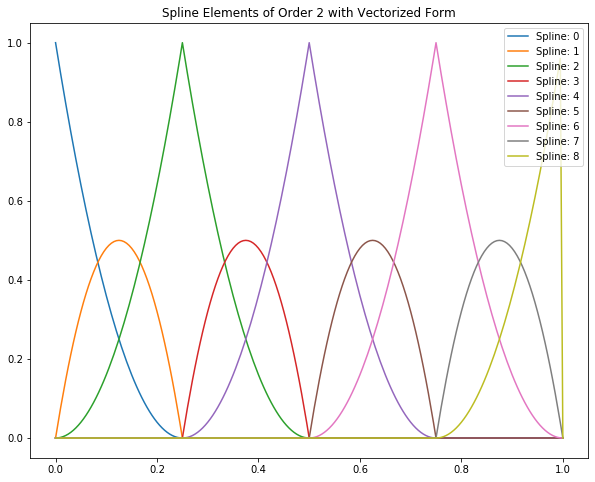

In [8]:
# Example 1 using vectorial naive bspline function: k order 2

knotss = [0,0,0,1/4,1/4,1/2,1/2,3/4,3/4,1,1,1]
k = 2
n = 9

jvalues = np.arange(0,n,1)

x_vector = np.arange(0,1.005,0.005)

plt.figure(figsize=(10,8))
plt.title(f'Spline Elements of Order {k} with Vectorized Form')
for jval in jvalues:
    sol = obj.bspline(x_vector,k,jval,knotss)
    plt.plot(x_vector , sol , label = f'Spline: {jval}')
plt.legend()
plt.show()

In [9]:
dx1 = 0.0001
print(dx1)

0.0001


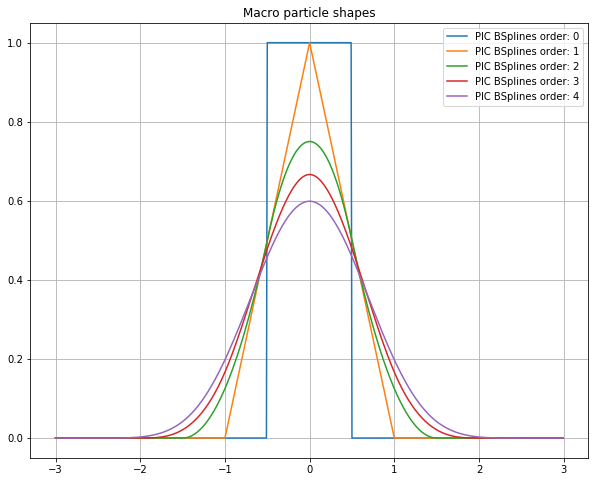

In [10]:
# Example 2: Create PIC Splines using the naive spline function

degrees = [0,1,2,3,4] # Degree of B-spline
j = 0
x_vector = np.arange(-0.0003,0.0003,0.000001)

plt.figure(figsize=(10,8))
for k in degrees:
    knot = obj.knot_function(k,dx1)
    n = len(knot) - k - 1
    sol = obj.bspline(x_vector,k,j,knot)
    plt.plot(x_vector/dx1 , sol , label = f'PIC BSplines order: {k}')
plt.title('Macro particle shapes')
plt.legend()
plt.grid(True)
plt.show()

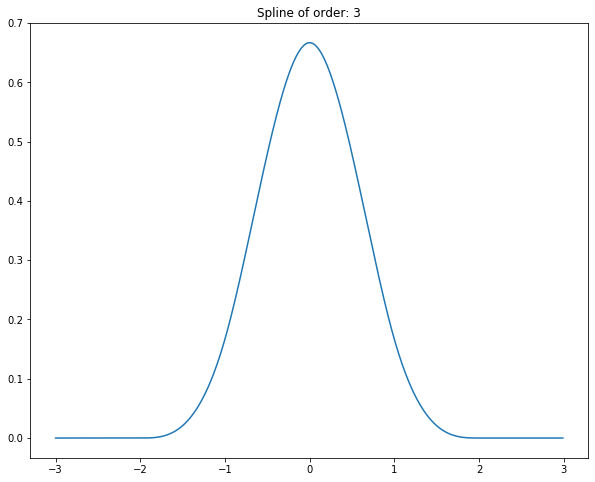

In [11]:
plt.figure(figsize=(10,8))
knot = obj.knot_function(3,dx1)
sol = obj.bspline(x_vector,3,0,knot)
plt.plot(x_vector/dx1 , sol )
plt.title(f'Spline of order: {3}')
plt.show()

## Scheme of the PIC Simulation

In [12]:
def initial_condition(x,v):
    return (1.0 + eps*np.cos(x)) * 1/np.sqrt(2*np.pi) * np.exp(-v**2/2)

In [13]:
x_grid = obj.grid_points(0.0, L_x, dx) # positions grid
v_grid = obj.grid_points(v_min, v_max, dv) # velocities grid
knot = obj.knot_function(3, dx) # Define the knots of the bspline function

In [14]:
# Calculation of weights
# Define the histogram of the particles distribution in phase space
H, xedges, yedges = np.histogram2d(obj.positions_sampling, obj.velocities_sampling, bins = (x_grid, v_grid),density = True)
H = H.T  # Let each row list bins with common y range.
H.shape

(256, 128)

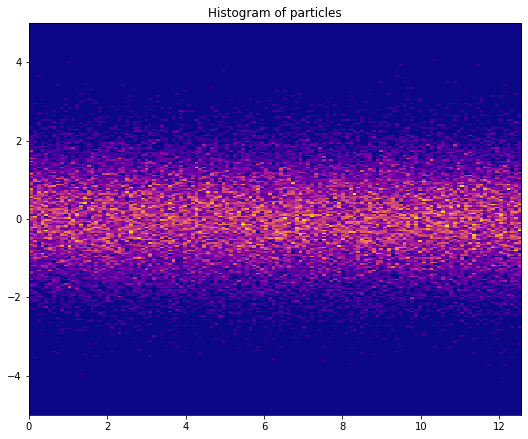

In [15]:
# Plot the 2d histogram of particle distributions
fig = plt.figure(figsize=(30, 30))
ax = fig.add_subplot(131, title='Histogram of particles' )
plt.imshow(H, interpolation='nearest', origin='lower',
        extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]],cmap = 'plasma')
plt.show()

In [16]:
wks = obj.calculate_weights(x_grid,v_grid,obj.positions_sampling,obj.velocities_sampling,H)
wks

array([0.0469367 , 0.02086076, 0.02607595, ..., 0.03129114, 0.01043038,
       0.04172151])

In [17]:
# Calculate the density at the mesh points
start = time.time()
density = obj.particle_density(obj.positions_sampling, obj.velocities_sampling, obj.positions_sampling,
                                       obj.velocities_sampling, x_grid, L_x, wks, N_k, obj.bspline, 
                                       knot, 0, 3, maxwell_control_var, sampling_dist)
end = time.time()
print((end-start)/60)

0.024568859736124674


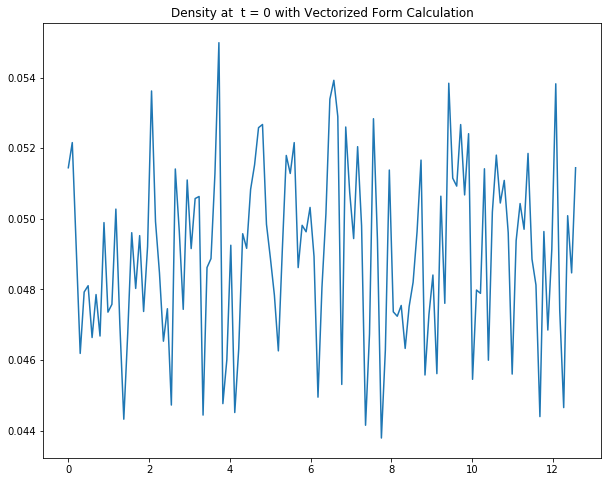

In [18]:
# Plot the density
plt.figure(figsize = (10,8))
plt.plot(x_grid , 1 - density, label = 'Density at t = 0')
plt.title('Density at  t = 0 with Vectorized Form Calculation')
plt.show()

In [19]:
# Calculate the electric potential using poissons equation
rho = 1.0 - density # rho function for poisson equation
phi_sol = PoissonSolvers.Poisson1D_Periodic_BC_Solver1(0, L_x, N_x, rho).run()

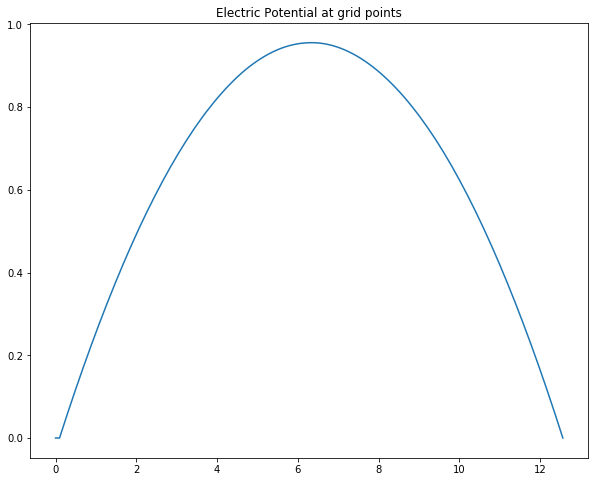

In [20]:
# Plot the electric potential
plt.figure(figsize = (10,8))
plt.plot(x_grid, phi_sol, label = 'Density at t = 0')
plt.title('Electric Potential at grid points')
plt.show()

In [21]:
# Calculate the electric field at grid points
E_field = -np.gradient(phi_sol, x_grid)

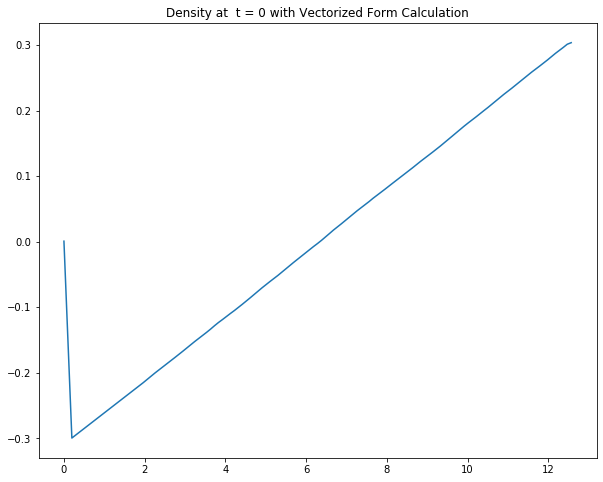

In [22]:
# Plot the electric field at grid points
plt.figure(figsize = (10,8))
plt.plot(x_grid , E_field, label = 'Density at t = 0')
plt.title('Density at  t = 0 with Vectorized Form Calculation')
plt.show()

In [23]:
def Electric_Field_Particle_Points(x_t, Nk, x_mesh, efield, Nx, Lx, bs_func, k_vec, sp_idx, spl_degree):
    ''' This function calculates the electric field in the particle positions with the contribution of 
        the electric field in each mesh point in the simulation at time t.
        x_t: Particle positions at time t
        x_mesh: x grid mesh
        efield: electric field evaluated in the mesh points at time t
        Lx: Positions size box u[0] = u[Lx]
        Nk: Number of markers (number of particles in simulation)
        bs_func: bspline function
        k_vec: knots vector
        sp_idx: spline element index
        spl_degree: spline degree '''
 
    if x_t.shape[0] != Nk:
        raise ValueError("Positions must have the dimension of markers")
    if x_mesh.shape[0] - 1 != Nx:
        raise ValueError("Mesh grid doesnt match the Nx slots")
    if efield.shape[0] - 1 != Nx:
        raise ValueError("Electric field dimension doesnt match Nx slots")
    
    deltax = Lx/Nx # Define the dx value
    
    X_t, X_mesh = np.meshgrid(x_t, x_mesh) # mesh grid for the particle positions and the mesh coordinates
    _, Efield = np.meshgrid(x_t, efield) # mesh grid for the particle positions and the electric field
    
    spline_factor = bs_func((X_t - X_mesh)%Lx, spl_degree, sp_idx, k_vec) # Shape (Nx,Nk)
    second_factor = spline_factor * Efield # Multiply the spline matrix by the electric field. Shape (Nx, Nk)
    term = sum(second_factor) # We sum over all grid points 
    term = term * deltax # multiply by dx

    return term

In [24]:
efield_particles = Electric_Field_Particle_Points(obj.positions_sampling, N_k, x_grid, E_field, N_x, L_x, 
                                                  obj.bspline, knot, 0, 3)

In [25]:
efield_particles

array([ 0.00311176,  0.00940076, -0.01436721, ..., -0.00673338,
       -0.00105387, -0.00745224])

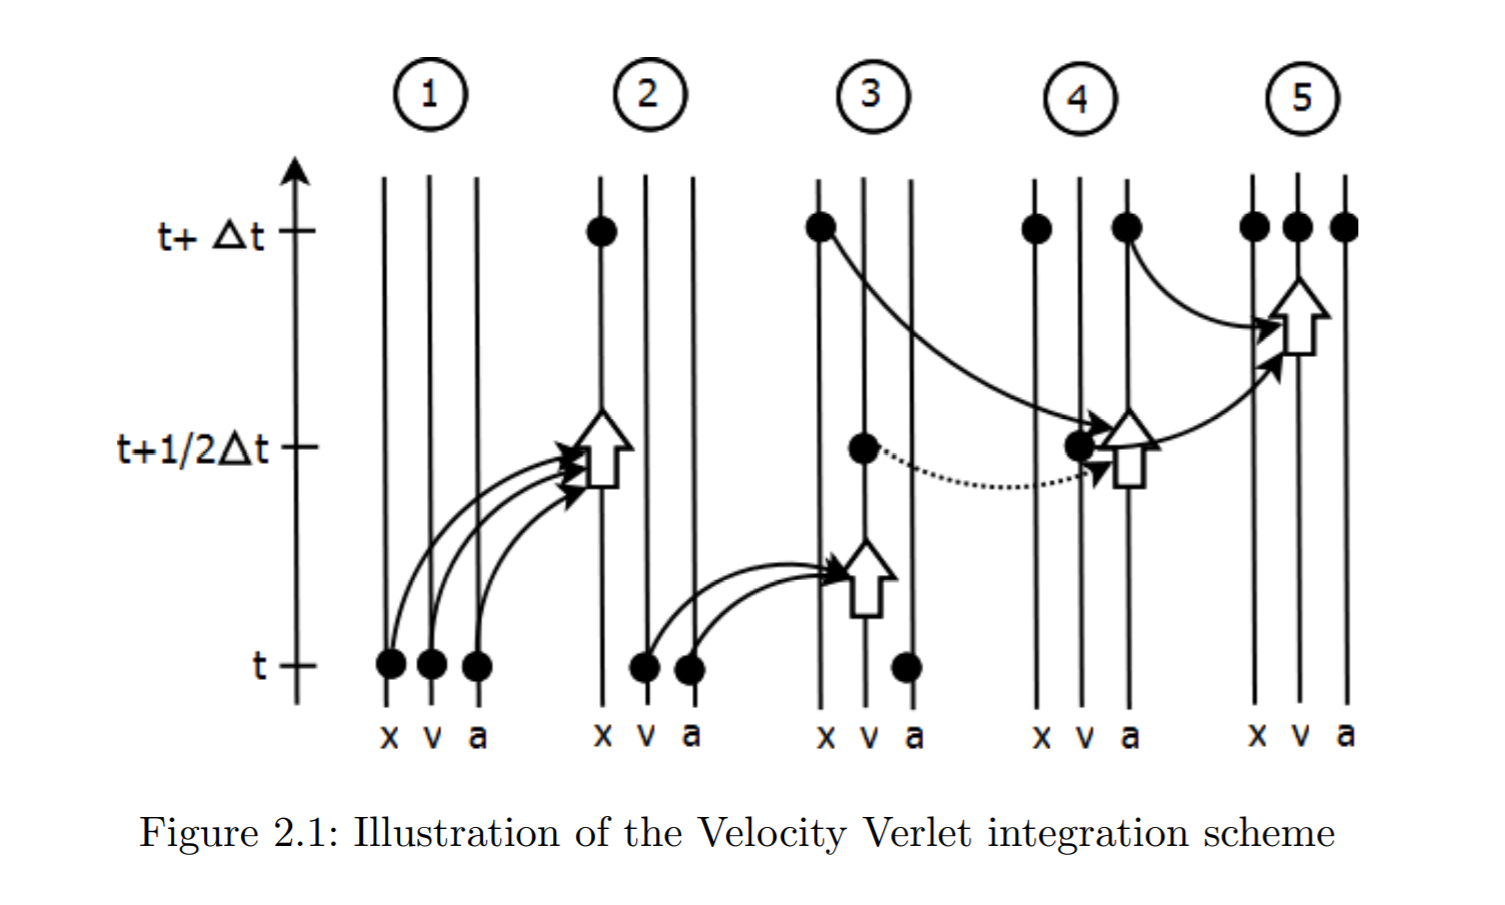

In [26]:
from IPython.display import Image
Image(filename='C:\\Users\\erik_\\Documents\\erik documents\\PUCP\\Fisica\\Plasma Physics\\\
PIC Codes Papers\\verlet_scheme.png',width = 600,height=600)

In [27]:
start_time = time.time()

obj.run_iteration()

end_time = time.time()
print('Total execution time: ',(end_time-start_time)/60.)

Total execution time:  12.79656641483307


In [28]:
data_pic = np.loadtxt("PIC1.txt")
data_pic.shape

(402, 50000)

In [29]:
data_pic = data_pic.reshape(M + 1, 2 , N_k)
data_pic.shape

(201, 2, 50000)

In [30]:
t_grid = obj.grid_points(0.0, T_max, dt)

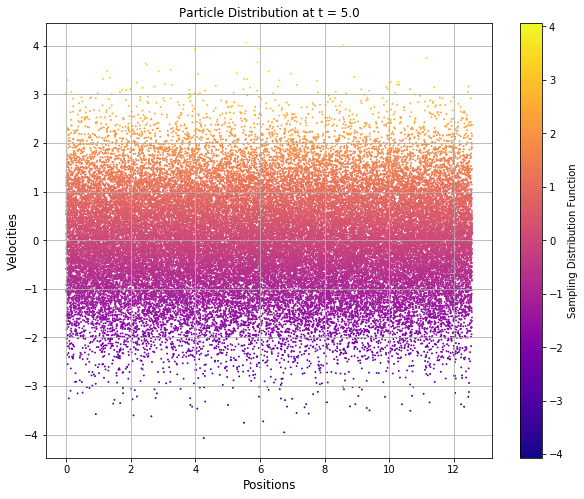

In [34]:
fig,ax = plt.subplots(figsize = (10,8))
ax.set_xlabel('Positions',fontsize = 'large')
ax.set_ylabel('Velocities',fontsize = 'large')
time_idx = 50
s = ax.scatter(data_pic[time_idx][0], data_pic[time_idx][1], s = 0.8,
               c = data_pic[time_idx][1],cmap='plasma')
plt. title(f'Particle Distribution at t = {t_grid[time_idx]}')
plt.grid()
fig.colorbar(s ,label = 'Sampling Distribution Function')
plt.show()

In [35]:
time_plot = [0, 40, 80, 120, 160, 200] #times to plot

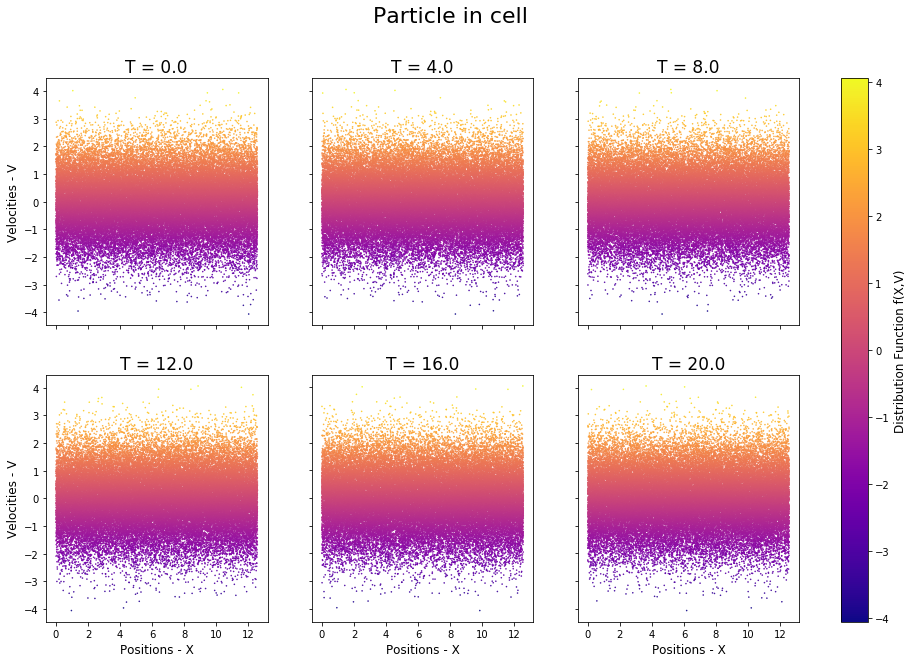

In [38]:
### Create plots of the distribution function at different times

fig, ax = plt.subplots(2, 3,figsize=(15,10))
fig.suptitle('Particle in cell',fontsize = 22) # general title

ti = 0 # index counter
images = [] # list to store images

for i in range(2): 
    for j in range(3):
        cp = ax[i,j].scatter(data_pic[time_plot[ti]][0], data_pic[time_plot[ti]][1], s = 0.3,
               c = data_pic[time_plot[ti]][1],cmap='plasma')
        ax[i,j].set_title(f'T = {time_plot[ti]*dt}',fontsize = 17) # create title
        images.append(cp) # save contour in list
        ti+=1 
        
# Add x and y labels
for axx in ax.flat:
    axx.set_xlabel('Positions - X',fontsize = 12)
    axx.set_ylabel('Velocities - V',fontsize = 12)

# Add a colorbar to a plot
cbar = fig.colorbar(images[0], ax=ax, orientation='vertical', fraction=.05)
cbar.ax.set_ylabel('Distribution Function f(X,V)',fontsize = 12)
    
# Hide x labels and tick labels for top plots and y ticks for right plots.
for axx in ax.flat:
    axx.label_outer()

In [64]:
eps = 0.5 # perturbation parameter
k_param = 0.5 # wave number
L_x = 2*np.pi / k_param # Size of grid
v_min = -10 # Minimum velocity 
v_max = 10 # Maximum velocity

In [65]:
def landau_initial_cond(x,v):
    return (1.0/np.sqrt(2.0*np.pi)) * np.exp(-v**2/2.0) * (1.0 + eps*np.cos(k_param*(x-L_x/2)))

In [66]:
N_x = 256 # Position Slots 
N_y = 256 # Velocities Slots 

# Step Sizes:
dx = L_x/N_x
dv = (v_max-v_min)/N_y

print(f'Nx: {N_x}     dx: {dx}')
print(f'Ny: {N_y}    dy: {dv}')

Nx: 256     dx: 0.04908738521234052
Ny: 256    dy: 0.078125


In [67]:
x_array = np.arange(0, L_x + dx, dx) # positions array
v_array = np.arange(v_min, v_max + dv, dv) # velocities array
Pos,Vel = np.meshgrid(x_array,v_array) # space-velocity mesh grid

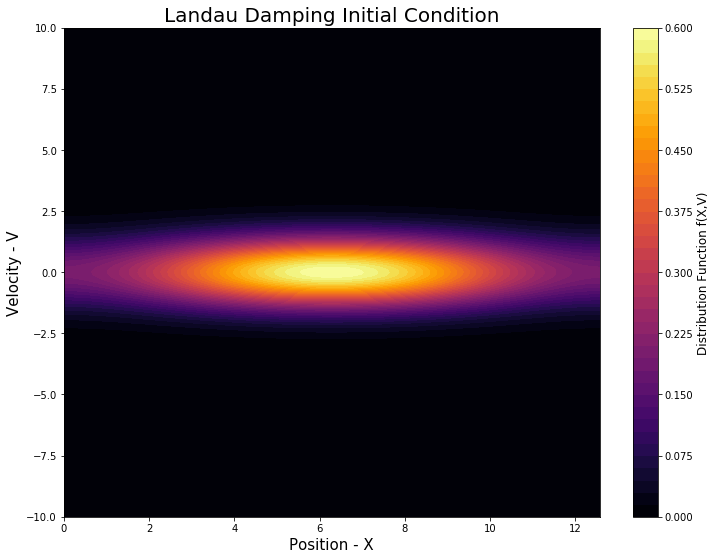

In [118]:
fig,ax = plt.subplots(1,1,figsize = (12, 9))
cp = ax.contourf(Pos, Vel , landau_initial_cond(Pos,Vel),50, cmap=cm.inferno) # Create contour plot
cbar = fig.colorbar(cp) # Add a colorbar to a plot
cbar.ax.set_ylabel('Distribution Function f(X,V)',fontsize = 12) # Label the color bar
plt.title('Landau Damping Initial Condition',fontsize = 20) # title
ax.set_xlabel('Position - X',fontsize = 15) # xlabel
ax.set_ylabel('Velocity - V',fontsize = 15) # ylabel
plt.show()

In [107]:
N_k = int(5e4) # Number of markers (particles)

sig = 3.5
mean = L_x/2
particle_x = norm.rvs(size = N_k, loc = mean, scale =sig)
particle_v = norm.rvs(size = N_k, loc = 0, scale = 1)

In [108]:
def sampling_dist2(x,v):
    dist1 = 1.0/(np.sqrt(2*np.pi)) * np.exp(-v**2/2)
    dist2 = 1.0/(np.sqrt(2*np.pi*sig**2)) * np.exp(-(x-mean)**2/(2*sig**2))
    return dist1*dist2

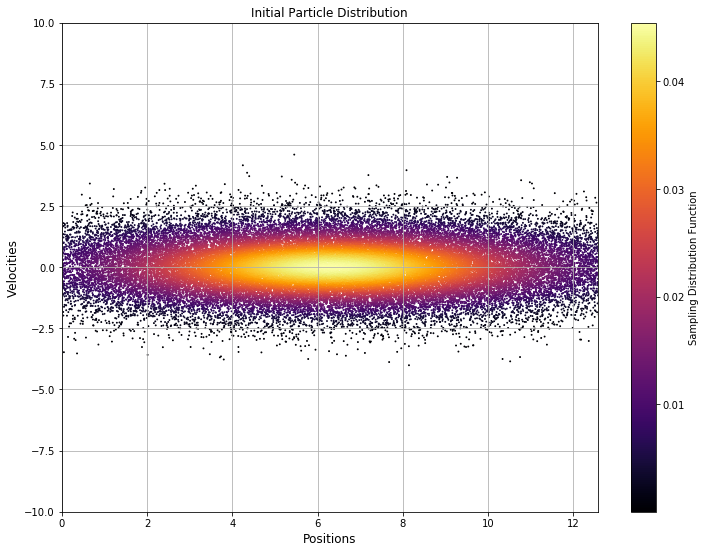

In [119]:
fig,ax = plt.subplots(figsize = (12,9))
ax.set_xlabel('Positions',fontsize = 'large')
ax.set_ylabel('Velocities',fontsize = 'large')
s = ax.scatter(particle_x, particle_v,s=0.8,c = sampling_dist2(particle_x,particle_v),cmap='inferno')
plt.title('Initial Particle Distribution')
plt.xlim([0, L_x])
plt.ylim([-10, 10])
plt.grid()
fig.colorbar(s ,label = 'Sampling Distribution Function')
plt.show()

In [122]:
def cosine(x):
    return 1.0 + eps*np.cos(k_param*(x-L_x/2))
sig = 3.5
def expp(x):
    return 1.0/(np.sqrt(2*np.pi*sig**2)) * np.exp(-(x-mean)**2/(2*sig**2))

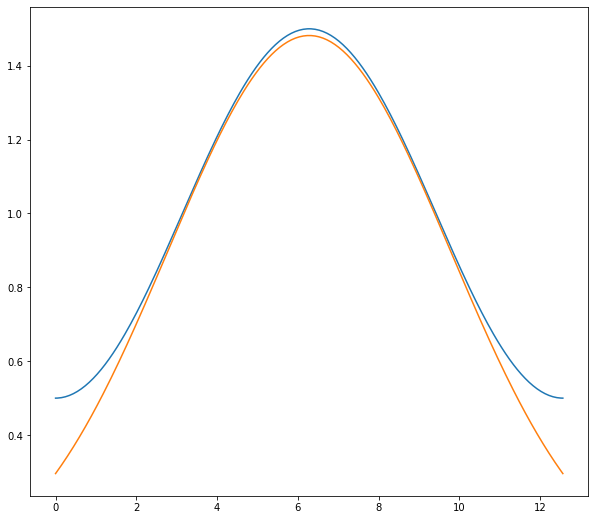

In [124]:
plt.figure(figsize = (10,9))
plt.plot(x_array,cosine(x_array))
plt.plot(x_array,expp(x_array)*13)